# Group 12 Guided Project
## 1. Introduction

## 2. Data Collection & Preprocessing

### 2.1 Data Collection

#### 2.1.1 Singapore Traffic Flow API

<p>To get the Singapore traffic flow data, API provided by Land Transpotation DataMall is used: <a>https://datamall2.mytransport.sg/ltaodataservice/TrafficFlow</a></p>

<p>Below code is used to call the API and get the provided data, which only include the daily peak hours (7-9am) traffic volume with location details in Feb 2024.</p>

<p>Details of traffic_flow_sg dataset: <b>average traffic volume per hour from 7-9 AM everyday in Feb 2024</b>.</p>

In [148]:
import requests
import pandas as pd

# url to call the api which will return the file link
url_get_traffic_flow_link = "https://datamall2.mytransport.sg/ltaodataservice/TrafficFlow"
apiKey = 'dZMBPqIXQrenFv/Qte43bw=='

# payload = {}
headers = {
  'AccountKey': apiKey,
  'accept': 'application/json'
}

api_response = requests.get(url_get_traffic_flow_link, headers=headers)
json_link = api_response.json()
url_data = pd.json_normalize(
        data=json_link,
        record_path='value',
        errors='ignore',
        sep ='.'
    )
# to get file link from returned result, which will expire after 5 mins
url_traffic_flow = url_data['Link'][0]

# to get the actual data via file link
link_response = requests.get(url_traffic_flow, headers=headers, timeout=(5, 15))
json_data = link_response.json()
traffic_flow_sg = pd.json_normalize(
            data=json_data,
            record_path='Value',
            meta=[
                'LastUpdatedDate'
            ],
            errors='ignore',
            sep ='.'
        )
# check the traffic flow data
traffic_flow_sg

,LinkID,Date,HourOfDate,Volume,StartLon,StartLat,EndLon,EndLat,RoadName,RoadCat,LastUpdatedDate
0,103000122,01/02/2024,7,3881,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
1,103000122,01/02/2024,8,4644,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
2,103000122,02/02/2024,7,4056,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
3,103000122,02/02/2024,8,4594,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
4,103000122,03/02/2024,7,2687,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
...,...,...,...,...,...,...,...,...,...,...,...
75496,118001452,27/02/2024,8,2629,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31
75497,118001452,28/02/2024,7,2171,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31
75498,118001452,28/02/2024,8,2510,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31
75499,118001452,29/02/2024,7,2204,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31


#### 2.1.2 Singapore Traffic Speed Bands API

<p>To get the Singapore traffic speed bands data, API provided by Land Transpotation DataMall is used: <a>https://datamall2.mytransport.sg/ltaodataservice/v3/TrafficSpeedBands</a></p>

<p>This API will return the current traffic speeds on expressways and arterial roads, each time will only return 500 records. Hence, the code below is to get all current traffic speed bands data, convert to panda frame format and save as .csv file (time: 2024-10-03 21:25:00) for further analysis.</p>

<p>Details of traffic_speed_bands_sg: current traffic speeds data will return if call again, <b>data used for analysis in this project <i>traffic_speed_bands_sg.csv</i> is data updated at 2024-10-03 21:25:00<b>.</p>

In [149]:
url_speed_bands = "https://datamall2.mytransport.sg/ltaodataservice/v3/TrafficSpeedBands?$skip={}"
apiKey = 'y4MnOaz/QmCC6O/5aUOa9A=='
headers = {
    'AccountKey': apiKey,
    'accept': 'application/json'
}

records_per_call = 500  # each call will return 500 records
data_list = []

skip = 0

while True:
    url = url_speed_bands.format(skip)
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        json_data = response.json()
        if not json_data:
            break

        df_data = pd.json_normalize(
            data=json_data,
            record_path='value',
            meta=[
                'odata.metadata',
                'lastUpdatedTime'
            ],
            errors='ignore',
            sep='.'
        )

        data_list.append(df_data)
        
        # if returned data is less than 500, then stop the while loop
        if len(json_data['value']) < records_per_call:
            break

        skip += records_per_call
    else:
        print(f"Failed to fetch data from skip {skip}")
        break

# combine all data together
traffic_speed_bands_sg = pd.concat(data_list, ignore_index=False)
traffic_speed_bands_sg

,LinkID,RoadName,RoadCategory,SpeedBand,MinimumSpeed,MaximumSpeed,StartLon,StartLat,EndLon,EndLat,odata.metadata,lastUpdatedTime
0,103000000,KENT ROAD,E,3,20,29,103.85298052044503,1.3170142376560023,103.85259882242372,1.3166840028663076,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:05:00
1,103000010,BUCKLEY ROAD,E,4,30,39,103.84102305136321,1.3166507852203482,103.84022564204443,1.316912438354752,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:05:00
2,103000011,BUCKLEY ROAD,E,4,30,39,103.84022564204443,1.316912438354752,103.84102305136321,1.3166507852203482,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:05:00
3,103000014,SHREWSBURY ROAD,E,4,30,39,103.84700267615683,1.3186726294030418,103.84711392225329,1.3180212058893457,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:05:00
4,103000015,SHREWSBURY ROAD,E,4,30,39,103.84711392225329,1.3180212058893457,103.84700267615683,1.3186726294030418,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1,117000671,WOODLANDS SECTOR 2,C,3,20,29,103.8092915537452,1.4605954861677752,103.80992406974497,1.4609072902904807,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:10:00
2,117000674,WOODLANDS AVENUE 10,C,7,60,69,103.8102700220811,1.461077477013782,103.8104326729758,1.4607500991003515,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:10:00
3,117000675,WOODLANDS AVENUE 10,C,6,50,59,103.8102700220811,1.461077477013782,103.81012544254958,1.4613606859884667,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:10:00
4,117000678,WOODLANDS AVENUE 10,C,6,50,59,103.81012544254958,1.4613606859884667,103.8102700220811,1.461077477013782,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-04 17:10:00


In [150]:
# save as .csv file for further analysis
traffic_speed_bands_sg.to_csv('traffic_speed_bands_sg.csv', index=False)

#### 2.1.3 Singapore Traffic Incidents API

<p>To get the Singapore traffic incidents data, API provided by Land Transpotation DataMall is used: <a>https://datamall2.mytransport.sg/ltaodataservice/TrafficIncidents</a></p>

<p>This API will return the current traffic incidents happening on the roads, the below code is used to get the data at the same time as Traffic Speed Bands data and save as .csv file (time: 2024-10-03 21:25:00) for further analysis.</p>

<p>Details of traffic_incidents_sg: current traffic incidents happening on roads will return if call again, <b>data used for analysis in this project <i>traffic_incidents_sg.csv</i> is data updated at 2024-10-03 21:25:00<b>.</p>

In [151]:
url_traffic_incidents = "https://datamall2.mytransport.sg/ltaodataservice/TrafficIncidents"
apiKey = 'y4MnOaz/QmCC6O/5aUOa9A=='
headers = {
    'AccountKey': apiKey,
    'accept': 'application/json'
}

api_response = requests.get(url_traffic_incidents, headers=headers)
json_data = api_response.json()
traffic_incidents_sg = pd.json_normalize(
        data=json_data,
        record_path='value',
        errors='ignore',
        sep ='.'
    )
traffic_incidents_sg

,Type,Latitude,Longitude,Message
0,Vehicle breakdown,1.388727,103.755079,(4/10)17:06 Vehicle breakdown on KJE (towards ...
1,Heavy Traffic,1.326476,103.870345,(4/10)17:04 Heavy Traffic on PIE (towards Tuas...
2,Heavy Traffic,1.359776,103.857908,(4/10)16:56 Heavy Traffic on CTE (towards SLE)...
3,Heavy Traffic,1.344398,103.860236,(4/10)16:55 Heavy Traffic on CTE (towards AYE)...
4,Vehicle breakdown,1.318596,103.843996,(4/10)16:52 Vehicle breakdown on Thomson Road ...
5,Obstacle,1.298903,103.780335,(4/10)16:47 Obstacle on AYE (towards Tuas) aft...
6,Vehicle breakdown,1.323936,103.744626,(4/10)16:35 Vehicle breakdown on AYE (towards ...
7,Heavy Traffic,1.330045,103.862951,(4/10)16:22 Heavy Traffic on PIE (towards Tuas...
8,Heavy Traffic,1.323951,103.744394,(4/10)16:09 Heavy Traffic on AYE (towards MCE)...
9,Roadwork,1.303762,103.910323,(4/10)15:53 Roadworks on ECP (towards Changi A...


In [152]:
# save as .csv file for further analysis
traffic_incidents_sg.to_csv('traffic_incidents_sg.csv', index=False)

#### 2.1.4 Singapore Pollutant Standards Index (PSI) API 
<p>To get the accurate Pollutant Standards Index (PSI) data, API provided by NEA (National Environment Agency) in SG Gov Data Website is used: <a>https://data.gov.sg/datasets/d_fe37906a0182569d891506e815e819b7/view</a></p>
<p>Below code enables users to input the date they want to check the PSI data, making it easy to get the PSI data for any specific date range. This makes the code clearer and more reusable.</p>

In [153]:
import requests
import pandas as pd
import time
#import backoff

class RateLimitError(Exception):
    pass

# create a function to call API with exception handling and retries
# @backoff.on_exception(backoff.expo, RateLimitError)
def call_API(url, retries = 3, delay = 1):
    for retry in range(retries):
        try:
            api_response = requests.get(url)
            api_response.raise_for_status()
            api_response_json = api_response.json()  
            return api_response_json 
        except requests.RequestException as e:
            print(f"Attempt {retry + 1} failed due to: {e}")
            if retry < retries - 1: 
                time.sleep(delay)  
            else:
                print("Retried for three times, now give up")
                return None
            

In [154]:
from datetime import datetime, timedelta

# get PSI data for given date
def get_psi_data_for_date(date):
    url = f"https://api-open.data.gov.sg/v2/real-time/api/psi?date={date}"
    data = call_API(url)
    if 'data' in data and 'items' in data['data'] and len(data['data']['items']) > 0:
        psi_readings = data['data']['items'][0]
        region_metadata = data['data']['regionMetadata']
        return psi_readings, region_metadata

# retrieve PSI data for target date
def get_psi_data_for_Feb_data():
    
    # give time range date
    start_date = datetime(2024, 2, 1)
    end_date = datetime(2024, 2, 29)
    
    all_psi_data = []
    all_region_data = []
    
    # get the data from 2024-02-01 to 2024-02-29
    current_date = start_date
    while current_date <= end_date:
        for hour in [7, 8]:
            date_str = current_date.strftime(f'%Y-%m-%dT{hour:02d}:00:00')
            psi_readings, region_metadata = get_psi_data_for_date(date_str)
            timestamp_str = psi_readings['timestamp']
            timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
            date_str = timestamp.date().isoformat()
            hour_of_date = timestamp.hour
            if psi_readings and region_metadata:
                for key, region_data in psi_readings['readings'].items():
                    for region, reading_value in region_data.items():
                        all_psi_data.append({
                            'region': region,
                            'date': date_str,
                            'timestamp': timestamp_str,
                            'hourOfDate': hour_of_date,
                            'reading_type': key,  
                            'reading_value': reading_value
                        })
                for region in region_metadata:
                    all_region_data.append({
                        'region': region['name'],
                        'latitude': region['labelLocation']['latitude'],
                        'longitude': region['labelLocation']['longitude']
                    })
        current_date += timedelta(days=1)
    
     # psi data df
    all_psi_sg = pd.DataFrame(all_psi_data)
    
    # region location data df
    all_region_sg = pd.DataFrame(all_region_data)
    
    return all_psi_sg, all_region_sg


def get_psi_data_for_single_date():
    
    # give single date
    single_date = "2024-10-03T21:25:00"
    
    single_psi_data = []
    single_region_data = []
    
    # get the single date data
    psi_readings, region_metadata = get_psi_data_for_date(single_date)
    if psi_readings and region_metadata:
        # store single_region_data
        for region in region_metadata:
            single_region_data.append({
                'region': region['name'],
                'latitude': region['labelLocation']['latitude'],
                'longitude': region['labelLocation']['longitude']
            })
        # store single_psi_readings
        timestamp_str = psi_readings['timestamp']
        timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
        date_str = timestamp.date().isoformat()
        hour_of_date = timestamp.hour
        for key, reading_data in psi_readings['readings'].items():
            for region, reading_value in reading_data.items():
                single_psi_data.append({
                    'region': region,
                    'date': date_str,
                    'timestamp': timestamp_str,
                    'hourOfDate': hour_of_date,
                    'reading_type': key,  
                    'reading_value': reading_value
                })
    
    # single psi data df
    single_psi_sg = pd.DataFrame(single_psi_data)
    
     # single psi data df
    single_region_sg = pd.DataFrame(single_region_data)
    
    return single_psi_sg, single_region_sg

In [155]:
all_psi_sg, all_region_sg = get_psi_data_for_Feb_data()

In [156]:
all_psi_sg

,region,date,timestamp,hourOfDate,reading_type,reading_value
0,west,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,9
1,east,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,6
2,central,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,8
3,south,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,7
4,north,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,10
...,...,...,...,...,...,...
3475,west,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,3
3476,east,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,4
3477,central,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,6
3478,south,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,3


In [157]:
all_region_sg

,region,latitude,longitude
0,west,1.35735,103.70
1,east,1.35735,103.94
2,central,1.35735,103.82
3,south,1.29587,103.82
4,north,1.41803,103.82
...,...,...,...
285,west,1.35735,103.70
286,east,1.35735,103.94
287,central,1.35735,103.82
288,south,1.29587,103.82


In [158]:
single_psi_sg, single_region_sg = get_psi_data_for_single_date()
single_psi_sg.to_csv('single_psi_sg.csv', index=False)

In [159]:
single_psi_sg

,region,date,timestamp,hourOfDate,reading_type,reading_value
0,west,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,6
1,east,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,8
2,central,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,11
3,south,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,4
4,north,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,7
5,west,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,28
6,east,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,56
7,central,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,85
8,south,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,32
9,north,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,53


#### 2.1.5 Singapore Monthly Motor Vehicle Population by Vehicle Type Data
<p>To get the Monthly Motor Vehicle Population, data provided by LTA (Land Transport Authority) in SG Gov Data Website is used: <a>https://data.gov.sg/datasets/d_2ecb009f1e1ec5a816a454944dec4022/view </a></p>
<p>The data is downloaded and then inserted to further review and analyze. </p>

In [160]:
import pandas as pd

sg_vehicle_df = pd.read_csv('vehicle_data_sg.csv')
print(sg_vehicle_df.count)

sg_vehicle_df.dropna(inplace=True)
sg_vehicle_df.drop_duplicates(inplace=True)

sg_vehicle_df['month'] = pd.to_datetime(sg_vehicle_df['month'], format='%Y-%m')
sg_vehicle_df['number'] = sg_vehicle_df['number'].astype(int)
sg_vehicle_df['vehicle_type'] = sg_vehicle_df['vehicle_type'].str.strip().str.title()

print(sg_vehicle_df.dtypes)

<bound method DataFrame.count of        month            vehicle_type  number
0    2012-01                    Cars  593555
1    2012-01             Rental cars   13970
2    2012-01                   Taxis   27059
3    2012-01                   Buses   17037
4    2012-01  Goods & other vehicles  159854
..       ...                     ...     ...
907  2024-08       Private Hire Cars   86453
908  2024-08                   Taxis   13352
909  2024-08                   Buses   18573
910  2024-08  Goods & other vehicles  166749
911  2024-08             Motorcycles  146301

[912 rows x 3 columns]>
month           datetime64[ns]
vehicle_type            object
number                   int64
dtype: object


### 2.2 Data Cleaning

#### 2.2.4 Singapore Pollutant Standard Index

<p>Singapore PSI data is then further checked for null values and duplicates.</p>

<p>After removing the duplicates and missing values, the date value is transferred to datetime format, while reading values is updated to numeric types to later analysis. </p>

In [161]:

# Check for missing values
print("Missing values in each column:\n", all_psi_sg.isnull().sum())

all_psi_sg.dropna(subset=['reading_value'], inplace=True)

# Check duplicates
duplicates = all_psi_sg.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    all_psi_sg.drop_duplicates(inplace=True)

all_psi_sg['date'] = pd.to_datetime(all_psi_sg['date'])
all_psi_sg['reading_value'] = pd.to_numeric(all_psi_sg['reading_value'], errors='coerce')


print(all_psi_sg.info())

Missing values in each column:
 region           0
date             0
timestamp        0
hourOfDate       0
reading_type     0
reading_value    0
dtype: int64
Number of duplicate rows: 60
<class 'pandas.core.frame.DataFrame'>
Index: 3420 entries, 0 to 3479
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   region         3420 non-null   object        
 1   date           3420 non-null   datetime64[ns]
 2   timestamp      3420 non-null   object        
 3   hourOfDate     3420 non-null   int64         
 4   reading_type   3420 non-null   object        
 5   reading_value  3420 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 187.0+ KB
None


In [162]:
# Count unique reading types
unique_reading_types = all_psi_sg['reading_type'].unique()
print(f"reading types: {unique_reading_types}")

reading types: ['o3_sub_index' 'no2_one_hour_max' 'o3_eight_hour_max'
 'psi_twenty_four_hourly' 'pm10_twenty_four_hourly' 'pm10_sub_index'
 'pm25_twenty_four_hourly' 'so2_sub_index' 'pm25_sub_index'
 'so2_twenty_four_hourly' 'co_eight_hour_max' 'co_sub_index']


In [163]:
import pandas as pd

# read the hk air quality data file
file_path = '202402_HK_air_quality.csv'

# Read the CSV file with specified encoding for Chinese characters
hk_air_quality_df = pd.read_csv(file_path, encoding='gbk')

print(hk_air_quality_df.head())

print(hk_air_quality_df.tail())

print(hk_air_quality_df.dtypes)

         日期 时间 中西区 南区 东区  观塘 深水埗  葵涌 荃湾 将军澳 元朗 屯门 东涌 大埔  沙田 北区 塔门 铜锣湾 中环 旺角
0  2024/2/1  1   4  3  4   4   4   3  3   4  3  3  3  3   3  3  3   4  4  4
1  2024/2/1  2   3  3  4   4   3   3  3   4  3  3  3  3   3  3  3   3  4  3
2  2024/2/1  3   3  3  3   3   3   3  3   4  3  3  3  3   3  3  3   3  3  3
3  2024/2/1  4   3  3  3   3   3   3  3   3  2  3  3  3   3  3  3   3  3  3
4  2024/2/1  5   3  3  3  3*   3  3*  3   3  2  3  3  3  3*  3  3   3  3  3
            日期     时间 中西区 南区 东区 观塘 深水埗 葵涌 荃湾 将军澳 元朗 屯门 东涌 大埔 沙田 北区 塔门 铜锣湾 中环  \
720  2024/2/29     21   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  3   
721  2024/2/29     22   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  2   
722  2024/2/29     23   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  2   
723  2024/2/29     24   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  2   
724  2024/2/29  每日最高值   4  4  5  4   5  5  5   4  4  5  4  5  4  4  4   5  5   

    旺角  
720  2  
721  2  
722  2  
723  2  
724  5  
日期     ob

In [164]:

# remove all *
hk_air_quality_df.replace(to_replace=r'\*', value='', regex=True, inplace=True)

# update date column to datetime format
hk_air_quality_df['日期'] = pd.to_datetime(hk_air_quality_df['日期'])

hk_air_quality_df.iloc[:, 2:] = hk_air_quality_df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

# for na values, fill in mean value
hk_air_quality_df.fillna(hk_air_quality_df.iloc[:, 2:].mean(), inplace=True)


print(hk_air_quality_df.head(10))

          日期  时间  中西区  南区  东区  观塘  深水埗  葵涌  荃湾  将军澳  元朗  屯门  东涌  大埔  沙田  北区  \
0 2024-02-01   1    4   3   4   4    4   3   3    4   3   3   3   3   3   3   
1 2024-02-01   2    3   3   4   4    3   3   3    4   3   3   3   3   3   3   
2 2024-02-01   3    3   3   3   3    3   3   3    4   3   3   3   3   3   3   
3 2024-02-01   4    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
4 2024-02-01   5    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
5 2024-02-01   6    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
6 2024-02-01   7    3   3   3   3    3   3   3    3   2   2   2   3   3   3   
7 2024-02-01   8    3   3   3   3    3   3   3    3   2   2   2   2   3   2   
8 2024-02-01   9    3   3   3   3    3   3   3    3   2   3   3   3   3   2   
9 2024-02-01  10    3   3   3   3    3   3   3    3   2   3   3   3   3   3   

    塔门  铜锣湾  中环  旺角  
0  3.0    4   4   4  
1  3.0    3   4   3  
2  3.0    3   3   3  
3  3.0    3   3   3  
4  3.0    3   3   3 

C:\Users\Admin\AppData\Local\Temp\ipykernel_27980\2340053571.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hk_air_quality_df.fillna(hk_air_quality_df.iloc[:, 2:].mean(), inplace=True)


In [165]:

filtered_hk_air_quality_df = hk_air_quality_df[(hk_air_quality_df['时间'] == '7') | (hk_air_quality_df['时间'] == '8')]
print("\nFiltered HK air quality data for hours 7 and 8 for comparision with SG data:")
print(filtered_hk_air_quality_df.head())


Filtered HK air quality data for hours 7 and 8 for comparision with SG data:
           日期 时间  中西区  南区  东区  观塘  深水埗  葵涌  荃湾  将军澳  元朗  屯门  东涌  大埔  沙田  北区  \
6  2024-02-01  7    3   3   3   3    3   3   3    3   2   2   2   3   3   3   
7  2024-02-01  8    3   3   3   3    3   3   3    3   2   2   2   2   3   2   
31 2024-02-02  7    2   2   2   2    3   2   2    2   2   2   2   2   2   2   
32 2024-02-02  8    2   2   2   2    3   2   2    2   2   2   2   2   2   2   
56 2024-02-03  7    3   3   3   3    3   3   3    3   2   3   3   3   3   3   

     塔门  铜锣湾  中环  旺角  
6   3.0    3   3   3  
7   2.0    3   3   3  
31  2.0    3   3   2  
32  2.0    3   3   2  
56  3.0    3   3   3  


In [166]:
# Insert new library to do naming translation from Chinese to English
from googletrans import Translator
translator = Translator()

def translate_column_names(df):
    translated_columns = {}
    for col in df.columns:
        # Translate Chinese column name to English
        translated_col = translator.translate(col, dest='en').text
        # use _ to replace the space
        translated_col = translated_col.replace(' ', '_')
        translated_columns[col] = translated_col
    
    # Rename the columns to English
    df.rename(columns=translated_columns, inplace=True)

translate_column_names(filtered_hk_air_quality_df)

print(filtered_hk_air_quality_df.head())


         date time  Central_and_Western_District  Southern_district  \
6  2024-02-01    7                             3                  3   
7  2024-02-01    8                             3                  3   
31 2024-02-02    7                             2                  2   
32 2024-02-02    8                             2                  2   
56 2024-02-03    7                             3                  3   

    Eastern_district  Guantang  Sham_Shui_Kan  Kwai  Tsuen_Wan  Tseungo  \
6                  3         3              3     3          3        3   
7                  3         3              3     3          3        3   
31                 2         2              3     2          2        2   
32                 2         2              3     2          2        2   
56                 3         3              3     3          3        3   

    Yuanlang  Tuomao  Tung_Chung  Tai_Po  Sand_field  Northern_district  \
6          2       2           2       3       

C:\Users\Admin\AppData\Local\Temp\ipykernel_27980\1721714791.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=translated_columns, inplace=True)


In [167]:
from time import sleep
import requests
import pandas as pd
import time

sdk_key = '77dc351e719e8d52a6588b2d49cf7e4a'
api_key = 'JzFUjwPOR5Kf5DdyGpAx6g=='
traffic_flow_api = 'https://datamall2.mytransport.sg/ltaodataservice/TrafficFlow'

def call_API_with_key(api_url, api_key, retries=1, delay=5):
    # Define headers
    headers = {
        'AccountKey': api_key,
        'accept': 'application/json' 
    }
    
    response = requests.get(api_url, headers=headers)
    response.raise_for_status()  
    data = response.json() 
    print(f"data response: {data}")
    
    for attempt in range(retries):
        try:
            response = requests.get(api_url, headers=headers)
            response.raise_for_status()  
            data = response.json() 
            print(f"data response: {data}")
            
            link = None
            if 'value' in data and len(data['value']) > 0 and 'Link' in data['value'][0]:
                link = data['value'][0]['Link']
            
            if link:
                print(f"Found link: {link}")

                # Make another GET request to the extracted link
                link_response = call_API(link)
                return link_response
            else:
                return None

        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds...")
                sleep(delay)
            else:
                print("Failed after several retries.")
                return None


traffic_flow_response = call_API_with_key(traffic_flow_api, api_key)
#if traffic_flow_response:
#    traffic_flow_df = pd.DataFrame(traffic_flow_response['Value'])
#    traffic_flow_filename = "traffic_flow_data.xlsx"
#    traffic_flow_df.to_excel(traffic_flow_filename, index=False)
#else:
#    print("Data is not in expected list format.")

data response: {'odata.metadata': 'http://datamall2.mytransport.sg/ltaodataservice/$metadata#TrafficFlow', 'value': [{'Link': 'https://dmprod-datasets.s3.ap-southeast-1.amazonaws.com/traffic-flow/data/trafficflow.json?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIj%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkYwRAIgbnr64zxTrKY70GPi7sHwrZyXZDXaJt9kX4eviUHuGMUCIDwkheP4zboRlvhlkwKFTcVReVG1HQPwpMeZAsnmf6HzKssFCNH%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQBBoMMzQwNjQ1MzgxMzA0IgwjWYbawQvI9Qad%2FksqnwV7VeYrTPVhoiAXGI6%2F5VMQysbCuaIuQAmccz1b4AkM58qslNivvK4%2Fl78624LFx13k5R%2BEM2kHuuxGJxo3hpw3IKcFB0UIzwrl9SuV33FHJEJLXkOBZdL%2Fnl%2FsxGmk1%2F2Us7%2FQ9H7AgnIzCqdKNc8xPSg8PvEmj56S0PcFtRszC%2B7BN%2FcbPnID4Lf48ojJ0LWtOIjJyMmd8PoiU9ODdp01pzZnoG9%2BMWhvt0T0Ynd4yfxXJNKReVGOlBIp1Cj2jHqqGs9K42IkdLataZiMirkJZ8tse2ne0hYWAK7JsJDHftDzEkpwb8CpULyn8Looe8vw%2BDGxtQxJzoyeI8mP%2FG6aFF3KAHDf%2F4S4Xz9jGj7%2FBE8XGG%2Fxigy%2FeVKgnFb4pgy3B7cd2LuhFwzNrq1q%2Fiz8TLj3ZHQk9ygOetZxtpLxuhJKQWnNrTe%2Biu%2BJwM5U6%2FuiRX0TEpJ%2BNJpGmM8x8

## 3. Exploratory Data Analysis (EDA)

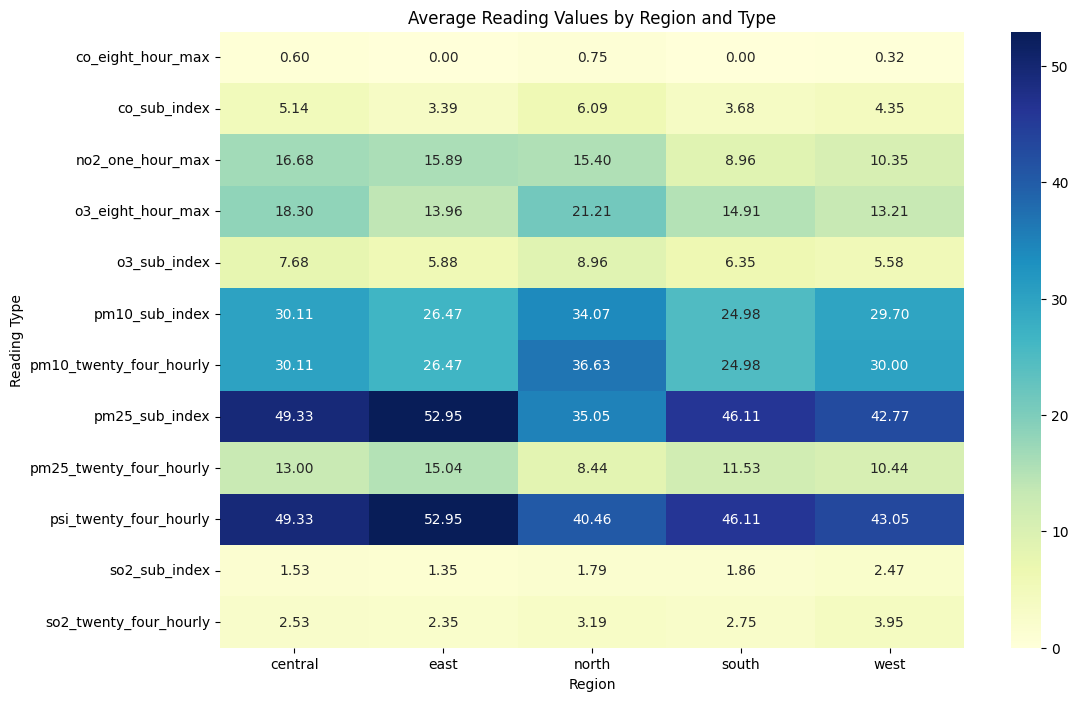

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

avg_readings = all_psi_sg.groupby(['reading_type','region'])['reading_value'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(avg_readings, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Average Reading Values by Region and Type')
plt.ylabel('Reading Type')
plt.xlabel('Region')
plt.show()

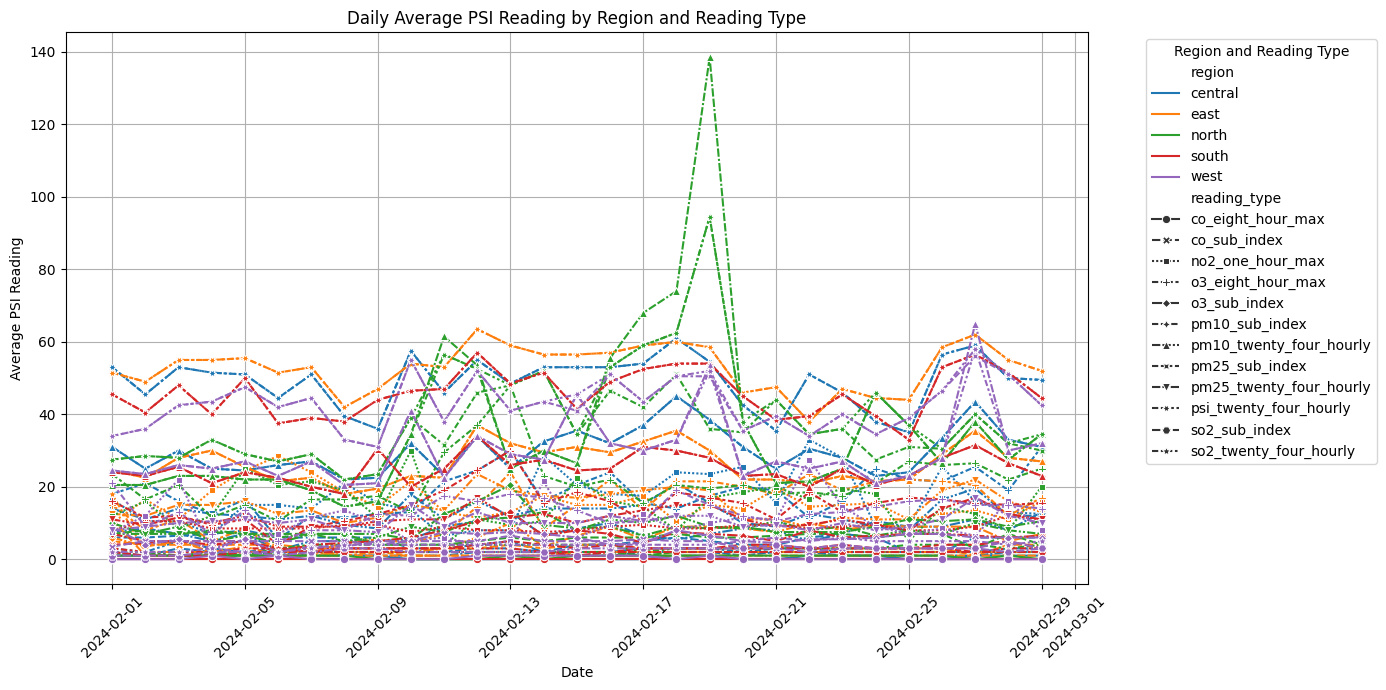

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


daily_average_psi = all_psi_sg.groupby(['date', 'region', 'reading_type'])['reading_value'].mean().reset_index()


plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_average_psi, x='date', y='reading_value', hue='region', style='reading_type', markers=True)
plt.title('Daily Average PSI Reading by Region and Reading Type')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.legend(title='Region and Reading Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


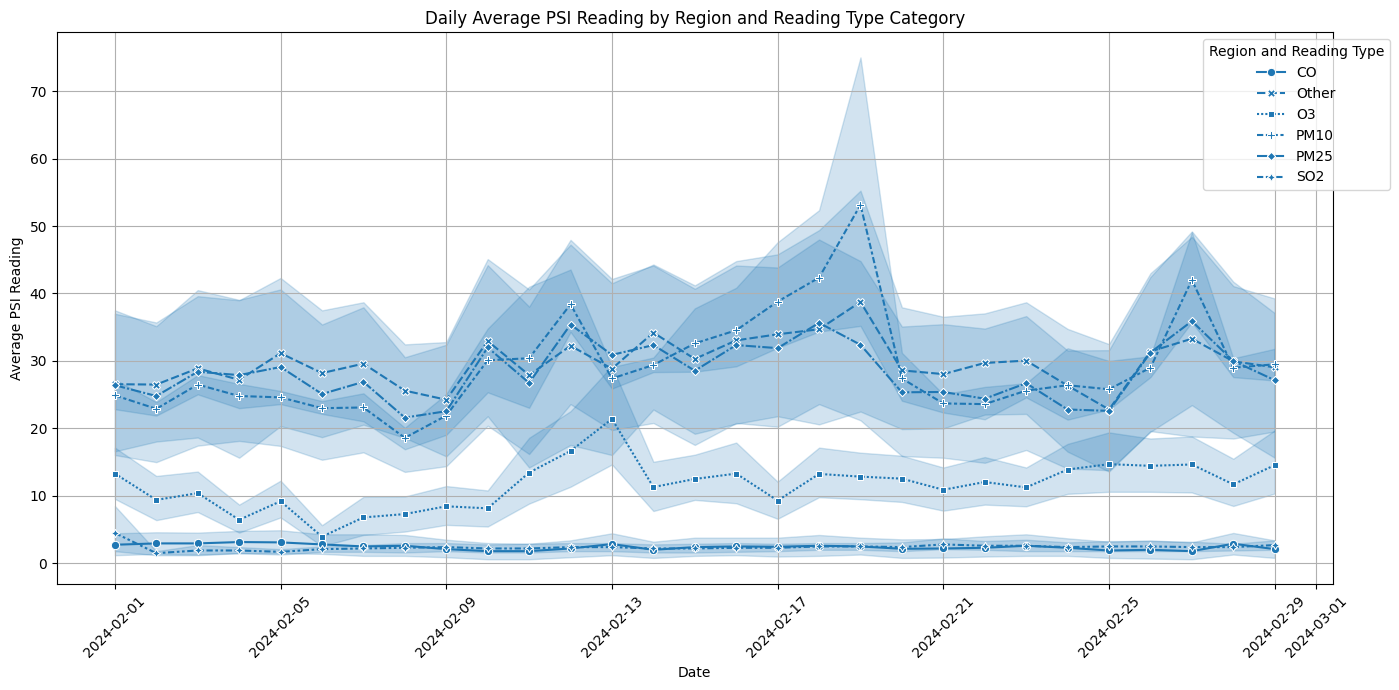

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


daily_average_psi = all_psi_sg.groupby(['date', 'region', 'reading_type'])['reading_value'].mean().reset_index()

def categorize_reading_type(reading_type):
    if reading_type.startswith('co'):
        return 'CO'
    elif reading_type.startswith('o3'):
        return 'O3'
    elif reading_type.startswith('pm10'):
        return 'PM10'
    elif reading_type.startswith('pm25'):
        return 'PM25'
    elif reading_type.startswith('so2'):
        return 'SO2'
    else:
        return 'Other'


daily_average_psi['category'] = daily_average_psi['reading_type'].apply(categorize_reading_type)

plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_average_psi, 
             x='date', 
             y='reading_value', 
             style='category', 
             markers=True)

plt.title('Daily Average PSI Reading by Region and Reading Type Category')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.legend(title='Region and Reading Type', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()


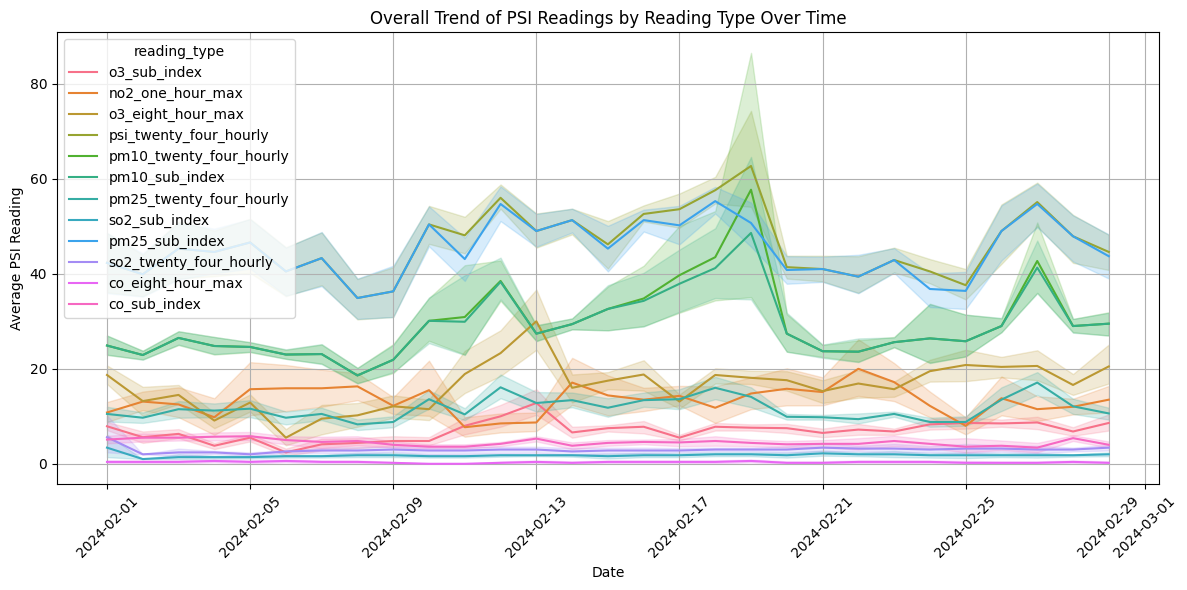

In [171]:
# Plotting the overall trend of PSI readings by reading type over the date range
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_psi_sg, x='date', y='reading_value', hue='reading_type', estimator='mean', markers=True)
plt.title('Overall Trend of PSI Readings by Reading Type Over Time')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


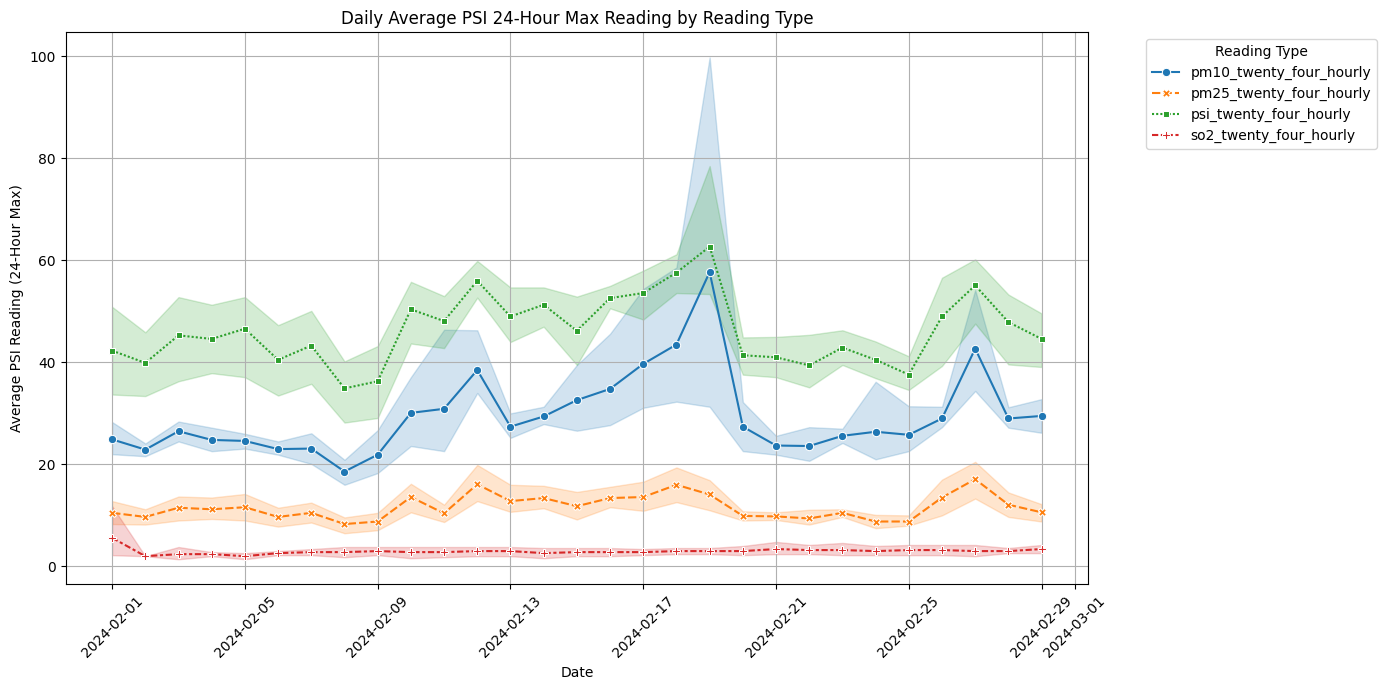

In [172]:
# only use data for 24-hour max readings
filtered_sg_air_data = daily_average_psi[daily_average_psi['reading_type'].str.contains('twenty_four_hourly')]


plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_sg_air_data, 
             x='date', 
             y='reading_value', 
             style='reading_type', 
             hue='reading_type',
             markers=True)

plt.title('Daily Average PSI 24-Hour Max Reading by Reading Type')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading (24-Hour Max)')
plt.xticks(rotation=45)
plt.legend(title='Reading Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

# Show plot
plt.show()


## 4. Data Modelling and Analysis

## 5. Comparative Analysis - Hong Kong

### 5.1 Data Collection

#### 5.1.1 Hong Kong Traffic Data
<p>The Hong Kong traffic data is sourced from the Hong Kong Government Data Center (Transport Department). The traffic data is collected by Traffic Detectors Installed at Smart Lampposts.Data format is XML, and update frequency is every 30 seconds.</p>
<p>You can access the data using the following link: <a href="https://data.gov.hk/en-data/dataset/hk-td-tis_33-traffic-data-traffic-detectors-installed-at-smart-lampposts/resource/b914e460-1042-4a25-8940-7a4687ef254b">Hong Kong Traffic Data</a>.</p>


In [178]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# to get the data from another folder in the directory
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, 'traffic_data_hk')

# check if the folder exists before processing
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Error: The folder path '{folder_path}' does not exist. Processing stopped.")
else:
    print(f"Start processing XML files from folder: {folder_path}")

hk_traffic_data = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith("-rawSpeedVol_SLP-all.xml"):
        file_path = os.path.join(folder_path, file_name)
        try:
            tree = ET.parse(file_path)
            root = tree.getroot()
            
            date = root.find('date').text
            
            for period in root.findall('./periods/period'):
                period_from = period.find('period_from').text
                period_to = period.find('period_to').text
                
                for detector in period.findall('./detectors/detector'):
                    detector_id = detector.find('detector_id').text
                    direction = detector.find('direction').text
                    
                    for lane in detector.findall('./lanes/lane'):
                        lane_id = lane.find('lane_id').text
                        speed = lane.find('speed').text
                        occupancy = lane.find('occupancy').text
                        volume = lane.find('volume').text
                        std_dev = lane.find('s.d.').text
                        valid = lane.find('valid').text
                        
                        # put data to list
                        hk_traffic_data.append({
                            'date': date,
                            'period_from': period_from,
                            'period_to': period_to,
                            'detector_id': detector_id,
                            'direction': direction,
                            'lane_id': lane_id,
                            'speed': speed,
                            'occupancy': occupancy,
                            'volume': volume,
                            'std_dev': std_dev,
                            'valid': valid
                        })
                        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")


hk_traffic_df = pd.DataFrame(hk_traffic_data)


print(hk_traffic_df.head())

print(hk_traffic_df.tail())



Start processing XML files from folder: c:\Users\Admin\Desktop\IS5126\group_project\G12_GuidedProject\traffic_data_hk
         date period_from period_to detector_id direction    lane_id speed  \
0  2024-02-16    06:53:00  06:53:30    AID20051      West  Fast Lane    29   
1  2024-02-16    06:53:00  06:53:30    AID20051      West  Slow Lane    50   
2  2024-02-16    06:53:00  06:53:30    AID20012      West  Fast Lane    50   
3  2024-02-16    06:53:00  06:53:30    AID20012      West  Slow Lane    50   
4  2024-02-16    06:53:00  06:53:30    AID20021      East  Fast Lane    52   

  occupancy volume std_dev valid  
0         7      2     3.5     Y  
1         0      0       0     Y  
2         0      0       0     Y  
3         0      0       0     Y  
4         8      1       0     Y  
             date period_from period_to detector_id direction      lane_id  \
35799  2024-02-29    08:02:30  08:03:00    AID20059     South    Fast Lane   
35800  2024-02-29    08:02:30  08:03:00    AID2

In [190]:
print(hk_traffic_df.describe())

                                date         speed     occupancy  \
count                          35804  35804.000000  35804.000000   
mean   2024-02-22 14:25:16.255166976     43.836052      5.856133   
min              2024-02-16 00:00:00      0.000000      0.000000   
25%              2024-02-19 00:00:00     34.000000      0.000000   
50%              2024-02-23 00:00:00     50.000000      2.000000   
75%              2024-02-26 00:00:00     50.000000      8.000000   
max              2024-02-29 00:00:00    172.000000     93.000000   
std                              NaN     12.904477      8.698036   

             volume       std_dev  
count  35804.000000  35804.000000  
mean       1.270445      1.532731  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        2.000000      1.700000  
max       15.000000     77.800000  
std        1.788407      3.604019  


#### 5.1.2 Hong Kong Air Quality Data



### 5.2 Data Cleaning


#### 5.2.1 Hong Kong Traffic Data
<p>To better utilize the HK traffic dataframe generated, data cleaning technics are used to convert numeric columns to numeric, and convert date column to datetime format. Additionally, missing values are also checked and dropped if any. </p>

In [179]:

# Data Cleaning
# Convert columns to numeric data types
hk_traffic_df['speed'] = pd.to_numeric(hk_traffic_df['speed'], errors='coerce')
hk_traffic_df['occupancy'] = pd.to_numeric(hk_traffic_df['occupancy'], errors='coerce')
hk_traffic_df['volume'] = pd.to_numeric(hk_traffic_df['volume'], errors='coerce')
hk_traffic_df['std_dev'] = pd.to_numeric(hk_traffic_df['std_dev'], errors='coerce')

# Convert 'date' column to datetime for time series analysis
hk_traffic_df['date'] = pd.to_datetime(hk_traffic_df['date'])

# Convert 'period_from' to datetime format for easier handling
hk_traffic_df['period_from'] = pd.to_datetime(hk_traffic_df['period_from'], format='%H:%M:%S').dt.time

# Check for missing values
missing_values = hk_traffic_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Drop rows with missing values
hk_traffic_df.dropna(inplace=True)

# Drop rows with invalid indicator
hk_traffic_df = hk_traffic_df[hk_traffic_df['valid'] == 'Y']

Missing values in each column:
date           0
period_from    0
period_to      0
detector_id    0
direction      0
lane_id        0
speed          0
occupancy      0
volume         0
std_dev        0
valid          0
dtype: int64


#### 5.1.2 Hong Kong Air Quality Data

In [180]:


def overall_average_air_quality(dataframe):
    # only have columns after first two to do average
    cols_to_convert = dataframe.columns[2:] 
    dataframe[cols_to_convert] = dataframe[cols_to_convert].apply(pd.to_numeric, errors='coerce')
    dataframe['air_average'] = dataframe[cols_to_convert].mean(axis=1)
    # group the average by date
    overall_avg_df = dataframe.groupby('date')['air_average'].mean().reset_index()
    return overall_avg_df


hk_average_air_quality_df = overall_average_air_quality(filtered_hk_air_quality_df)

hk_average_air_quality_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_27980\1192337851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[cols_to_convert] = dataframe[cols_to_convert].apply(pd.to_numeric, errors='coerce')
C:\Users\Admin\AppData\Local\Temp\ipykernel_27980\1192337851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['air_average'] = dataframe[cols_to_convert].mean(axis=1)


,date,air_average
0,2024-02-01,2.750000
1,2024-02-02,2.166667
2,2024-02-03,2.944444
3,2024-02-04,2.944444
4,2024-02-05,2.416667


In [181]:
hk_average_air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         29 non-null     datetime64[ns]
 1   air_average  29 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 596.0 bytes


In [182]:

hk_traffic_df.head()
print(hk_traffic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         35804 non-null  datetime64[ns]
 1   period_from  35804 non-null  object        
 2   period_to    35804 non-null  object        
 3   detector_id  35804 non-null  object        
 4   direction    35804 non-null  object        
 5   lane_id      35804 non-null  object        
 6   speed        35804 non-null  int64         
 7   occupancy    35804 non-null  int64         
 8   volume       35804 non-null  int64         
 9   std_dev      35804 non-null  float64       
 10  valid        35804 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 3.0+ MB
None


### 5.3 Exploratory Data Analysis (EDA) Snapshot of Hong Kong

In [ ]:
corr_matrix = filtered_hk_air_quality_df.drop(columns=['date', 'time']).corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Spectral')
plt.title('Correlation of Air Quality and Region')
plt.show()

In [ ]:

# Finding the date with the largest volume
max_volume_row = hk_traffic_df.loc[hk_traffic_df['volume'].idxmax()]
print("\nDate with the largest volume:")
print(f"Date: {max_volume_row['date']}, Volume: {max_volume_row['volume']}, Detector ID: {max_volume_row['detector_id']}")

# Grouping by date to analyze total volume per day
daily_volume = hk_traffic_df.groupby('date')['volume'].sum().reset_index()

# Plotting daily volume over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_volume, x='date', y='volume', marker='o')
plt.title('Daily Total Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [183]:
merge_hk_traffic_air_df = pd.merge(hk_average_air_quality_df, hk_traffic_df,on='date' )

In [184]:
data_encoded = pd.get_dummies(merge_hk_traffic_air_df, columns=['detector_id', 'direction', 'lane_id'], dtype=int)
# Display the first few rows of the encoded DataFrame
data_encoded.head()

,date,air_average,period_from,period_to,speed,occupancy,volume,std_dev,valid,detector_id_AID20011,...,detector_id_AID20058,detector_id_AID20059,detector_id_AID20060,direction_East,direction_North,direction_South,direction_West,lane_id_Fast Lane,lane_id_Middle Lane,lane_id_Slow Lane
0,2024-02-16,2.805556,06:53:00,06:53:30,29,7,2,3.5,Y,0,...,0,0,0,0,0,0,1,1,0,0
1,2024-02-16,2.805556,06:53:00,06:53:30,50,0,0,0.0,Y,0,...,0,0,0,0,0,0,1,0,0,1
2,2024-02-16,2.805556,06:53:00,06:53:30,50,0,0,0.0,Y,0,...,0,0,0,0,0,0,1,1,0,0
3,2024-02-16,2.805556,06:53:00,06:53:30,50,0,0,0.0,Y,0,...,0,0,0,0,0,0,1,0,0,1
4,2024-02-16,2.805556,06:53:00,06:53:30,52,8,1,0.0,Y,0,...,0,0,0,1,0,0,0,1,0,0


In [185]:
from sklearn.preprocessing import StandardScaler

# Identify the numerical columns to standardize
numerical_cols = ['speed', 'occupancy', 'volume', 'std_dev']

# Standardize the numerical columns
scaler = StandardScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

# Display the first few rows of the standardized DataFrame
data_encoded.head()


,date,air_average,period_from,period_to,speed,occupancy,volume,std_dev,valid,detector_id_AID20011,...,detector_id_AID20058,detector_id_AID20059,detector_id_AID20060,direction_East,direction_North,direction_South,direction_West,lane_id_Fast Lane,lane_id_Middle Lane,lane_id_Slow Lane
0,2024-02-16,2.805556,06:53:00,06:53:30,-1.149699,0.131510,0.407942,0.545862,Y,0,...,0,0,0,0,0,0,1,1,0,0
1,2024-02-16,2.805556,06:53:00,06:53:30,0.477666,-0.673280,-0.710388,-0.425290,Y,0,...,0,0,0,0,0,0,1,0,0,1
2,2024-02-16,2.805556,06:53:00,06:53:30,0.477666,-0.673280,-0.710388,-0.425290,Y,0,...,0,0,0,0,0,0,1,1,0,0
3,2024-02-16,2.805556,06:53:00,06:53:30,0.477666,-0.673280,-0.710388,-0.425290,Y,0,...,0,0,0,0,0,0,1,0,0,1
4,2024-02-16,2.805556,06:53:00,06:53:30,0.632653,0.246481,-0.151223,-0.425290,Y,0,...,0,0,0,1,0,0,0,1,0,0


In [186]:
# Select relevant features
features = data_encoded[['speed', 'occupancy', 'volume', 'air_average']]

print(features)

          speed  occupancy    volume  air_average
0     -1.149699   0.131510  0.407942     2.805556
1      0.477666  -0.673280 -0.710388     2.805556
2      0.477666  -0.673280 -0.710388     2.805556
3      0.477666  -0.673280 -0.710388     2.805556
4      0.632653   0.246481 -0.151223     2.805556
...         ...        ...       ...          ...
35799 -1.227192   0.821331  2.085436     3.277778
35800 -0.839724  -0.328370  0.407942     3.277778
35801  0.477666  -0.673280 -0.710388     3.277778
35802 -1.459673   0.706361  0.967106     3.277778
35803 -1.382179   1.856062  6.558753     3.277778

[35804 rows x 4 columns]


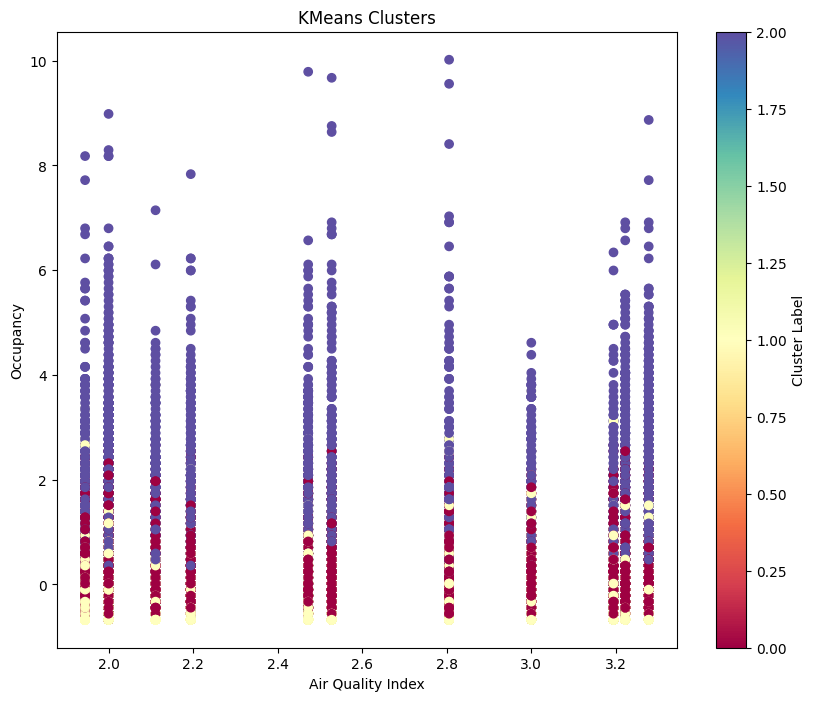

In [187]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Apply k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
data_encoded['KMeans_Labels'] = kmeans.fit_predict(features)

# Scatter plot for KMeans clusters (using 'speed' and 'occupancy' for visualization)
plt.figure(figsize=(10,8))
plt.scatter(data_encoded['air_average'], 
            data_encoded['occupancy'], 
            c=data_encoded['KMeans_Labels'], cmap='Spectral')
plt.title('KMeans Clusters')
plt.xlabel('Air Quality Index')
plt.ylabel('Occupancy')
plt.colorbar(label='Cluster Label')
plt.show()

In [188]:
# Print the count of each unique K-Means cluster label in the 'KMeans_Labels' column
print(data_encoded['KMeans_Labels'].value_counts())

KMeans_Labels
1    22084
0     9948
2     3772
Name: count, dtype: int64


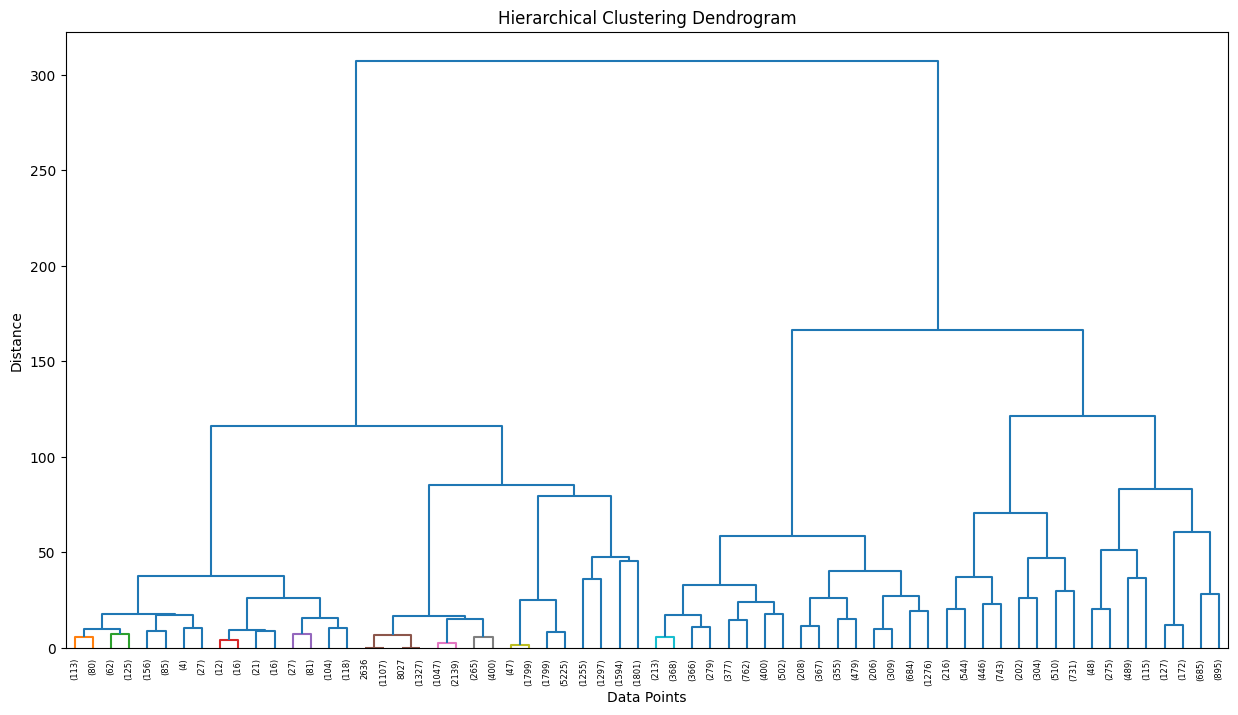

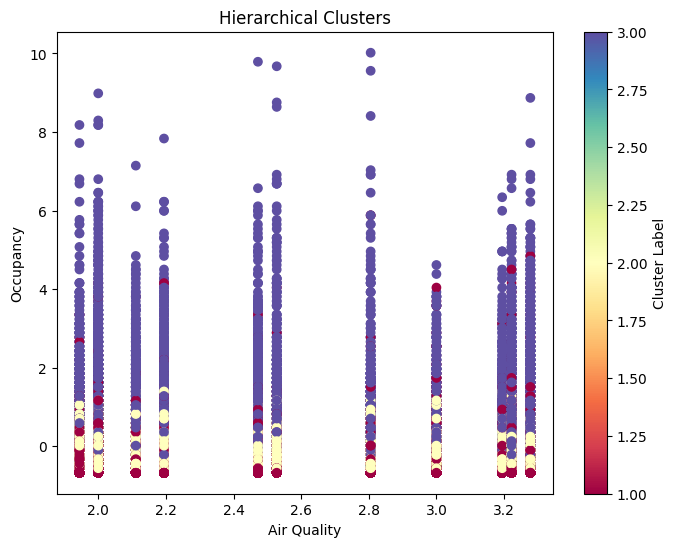

In [189]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Select relevant data columns for clustering
features = data_encoded[['speed', 'occupancy', 'volume', 'air_average']]

# Create a new linkage matrix with a different variable name
linkage_matrix = linkage(features, method='ward')

# Plot dendrogram to visualize the hierarchical structure
plt.figure(figsize=(15, 8))

# p limits the depth and truncate model limits the displayed cluster number
dendrogram(linkage_matrix, truncate_mode='level', color_threshold=7.8, p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Choose the number of clusters for subclustering (in this case, 3)
num_clusters = 3

# Assign labels to the cluster based on the number of clusters chosen
cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Assign the cluster labels to the DataFrame
data_encoded['Hierarchical_Labels'] = cluster_labels

# Scatter plot for the clusters (visualizing 'volume' and 'occupancy')
plt.figure(figsize=(8, 6))
plt.scatter(data_encoded['air_average'], 
            data_encoded['occupancy'], 
            c=data_encoded['Hierarchical_Labels'], cmap='Spectral')
plt.title('Hierarchical Clusters')
plt.xlabel('Air Quality')
plt.ylabel('Occupancy')
plt.colorbar(label='Cluster Label')
plt.show()


## 6. Conclusions and Recommendations

## 7. References

## 8. API URLs

### SG
##### Vehicle: https://data.gov.sg/datasets/d_2ecb009f1e1ec5a816a454944dec4022/view
##### PSI: https://data.gov.sg/datasets/d_fe37906a0182569d891506e815e819b7/view --> endpoint https://api-open.data.gov.sg/v2/real-time/api/psi?date={date}

### HK
##### Traffic: https://data.gov.hk/en-data/dataset/hk-td-tis_33-traffic-data-traffic-detectors-installed-at-smart-lampposts/resource/b914e460-1042-4a25-8940-7a4687ef254b
